In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neural_network as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [120]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [121]:
print(df.isnull().sum())
print(df.dtypes)


lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64
lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object


In [122]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [123]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,0.0,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NA,5,71016.0,self_employed,north_america,0,0.25,1


In [ ]:
X_train_val, X_val = train_test_split(df, test_size=0.2, random_state=1)
X_train, X_test = train_test_split(X_train_val, test_size=0.25, random_state=1)

y_train = X_train["converted"]
y_val = X_val["converted"]
y_test = X_test["converted"]

# del X_train["converted"]
# del X_val["converted"]
# del X_test["converted"]

number_of_courses_viewed 0.76
annual_income 0.55
interaction_count 0.74
lead_score 0.61


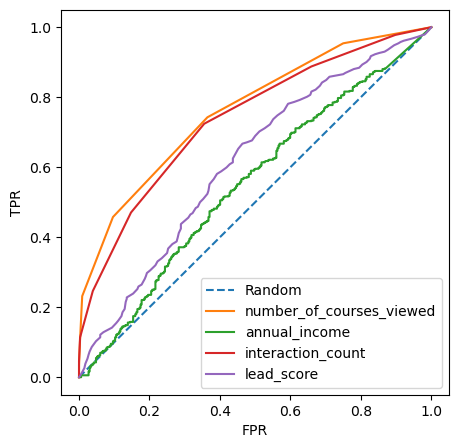

In [125]:
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

for col in numerical:
    fpr, tpr, thresholds = roc_curve(y_train, X_train[col])
    plt.plot(fpr, tpr, label=f'{col}')
    print(col, round(auc(fpr, tpr), 2))

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# number_of_courses_viewed

In [126]:
dv = DictVectorizer(sparse=False)

x_rec_train = X_train[numerical + categorical].to_dict(orient='records')
x_train_dv = dv.fit_transform(x_rec_train)

x_rec_val = X_val[numerical + categorical].to_dict(orient='records')
x_val_dv = dv.transform(x_rec_val)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(x_train_dv, y_train)

y_val_pred = model.predict(x_val_dv)

roc_auc_score(y_val, y_val_pred)

# 0.64


0.647564950627936

=====
precision = recall at t = 0.64 
F1max = 0.8124999999999999 at t = 0.5700000000000001


Text(0.5, 0, 'Threshold')

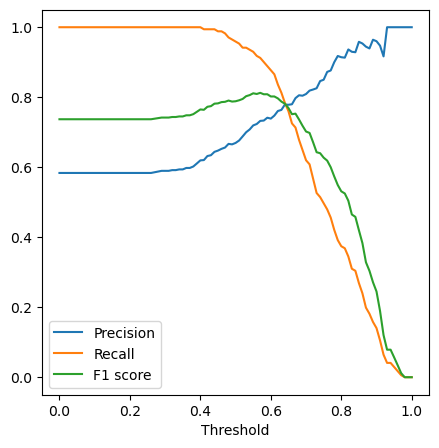

In [127]:
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    probs = model.predict_proba(x_val_dv)[:,1]

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (probs >= t)
    predict_negative = (probs < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if tp == 0 and fp == 0:
        precision = 1
    else:
        precision = tp / (tp + fp)
    
    if tp == 0 and fn == 0:
        recall = 1
    else:
        recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    if (abs(precision-recall) <= 0.01):
        print("=====\nprecision = recall at t =", t,"\n======")

index = np.argmax(f1s)
print(f"F1max = {f1s[index]} at t = {thresholds[index]}")

plt.figure(figsize=(5, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 score')
plt.legend()
plt.xlabel("Threshold")

# precision = recall at 0.64
# f1 is max at t = 0.57

In [128]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [129]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(X_train_val):
    df_train = X_train_val.iloc[train_idx]
    df_val = X_train_val.iloc[val_idx]

    y_train = df_train["converted"].values
    y_val = df_val["converted"].values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (1.0, np.mean(scores), np.std(scores)))

# stdev = 0.036

C=1.0 0.822 +- 0.036


In [130]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(X_train_val):
        df_train = X_train_val.iloc[train_idx]
        df_val = X_train_val.iloc[val_idx]

        y_train = df_train["converted"].values
        y_val = df_val["converted"].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

# c=0.001 is best

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
